In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV, cross_validate,RandomizedSearchCV

from sklearn.ensemble import GradientBoostingRegressor

In [9]:
# EDA

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Describe #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T, end="\n\n")

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()


def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list


def target_correlation_matrix(dataframe, corr_th=0.5, target="Salary"):
    """
    Bağımlı değişken ile verilen threshold değerinin üzerindeki korelasyona sahip değişkenleri getirir.
    :param dataframe:
    :param corr_th: eşik değeri
    :param target:  bağımlı değişken ismi
    :return:
    """
    corr = dataframe.corr()
    corr_th = corr_th
    try:
        filter = np.abs(corr[target]) > corr_th
        corr_features = corr.columns[filter].tolist()
        sns.clustermap(dataframe[corr_features].corr(), annot=True, fmt=".2f")
        plt.show()
        return corr_features
    except:
        print("Yüksek threshold değeri, corr_th değerinizi düşürün!")

In [10]:
# DataPrep
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [11]:
# ALL MODELS
def all_models(X, y, test_size=0.2, random_state=12345, classification=True):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
        roc_auc_score, confusion_matrix, classification_report, plot_roc_curve, mean_squared_error
    import numpy as np
    import pandas as pd

    # Tum Base Modeller (Classification)
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from catboost import CatBoostClassifier
    from lightgbm import LGBMClassifier
    from sklearn.svm import SVC

    # Tum Base Modeller (Regression)
    from catboost import CatBoostRegressor
    from lightgbm import LGBMRegressor
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.svm import SVR
    from sklearn.tree import DecisionTreeRegressor
    from xgboost import XGBRegressor
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    all_models = []

    if classification:
        models = [('LR', LogisticRegression(random_state=random_state)),
                  ('KNN', KNeighborsClassifier()),
                  ('CART', DecisionTreeClassifier(random_state=random_state)),
                  ('RF', RandomForestClassifier(random_state=random_state)),
                  ('SVM', SVC(gamma='auto', random_state=random_state)),
                  ('XGB', GradientBoostingClassifier(random_state=random_state)),
                  ("LightGBM", LGBMClassifier(random_state=random_state)),
                  ("CatBoost", CatBoostClassifier(verbose=False, random_state=random_state))]

        for name, model in models:
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            acc_train = accuracy_score(y_train, y_pred_train)
            acc_test = accuracy_score(y_test, y_pred_test)
            r2_train = r2_score(y_train, y_pred_train)
            r2_test = r2_score(y_test, y_pred_test)
            acc_test = accuracy_score(y_test, y_pred_test)
            values = dict(name=name, acc_train=acc_train, acc_test=acc_test, R2_TRAIN=r2_train, R2_TEST=r2_test)
            all_models.append(values)

        sort_method = False
    else:
        models = [('LR', LinearRegression()),
                  ("Ridge", Ridge()),
                  ("Lasso", Lasso()),
                  ("ElasticNet", ElasticNet()),
                  ('KNN', KNeighborsRegressor()),
                  ('CART', DecisionTreeRegressor()),
                  ('RF', RandomForestRegressor()),
                  ('SVR', SVR()),
                  ('GBM', GradientBoostingRegressor()),
                  ("XGBoost", XGBRegressor()),
                  ("LightGBM", LGBMRegressor()),
                  ("CatBoost", CatBoostRegressor(verbose=False))]

        for name, model in models:
            model.fit(X_train, y_train)
            y_pred_test = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            r2_train = r2_score(y_train,y_pred_train)
            r2_test = r2_score(y_test,y_pred_test)
            values = dict(name=name, RMSE_TRAIN=rmse_train, RMSE_TEST=rmse_test,R2_TRAIN=r2_train,R2_TEST=r2_test)            
            all_models.append(values)

        sort_method = True
    all_models_df = pd.DataFrame(all_models)
    all_models_df = all_models_df.sort_values(all_models_df.columns[2], ascending=sort_method)
    print(all_models_df)
    return all_models_df

In [12]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [13]:
# veri hakkinda genel bilgi edinelim

check_df(df)
# eksik deger yok

##################### Shape #####################
(1338, 7)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
##################### Head #####################
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
##################### Tail #####################
      age     sex    bmi  children smoker     region     charges
1333   50    male  30.97         3     no  northwest  10600.5483
1334   18  female  31.92         0     no  northeast   2205.9808
1335   18  female  36.85         0     no  southeast   1629

In [14]:
# numerik ve kategorik degiskenlerin yakalanmasi
cat_col, num_col, cat_but_car = grab_col_names(df)

Observations: 1338
Variables: 7
cat_cols: 4
num_cols: 3
cat_but_car: 0
num_but_cat: 1


count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
5%         18.000000
10%        19.000000
20%        24.000000
30%        29.000000
40%        34.000000
50%        39.000000
60%        44.000000
70%        49.000000
80%        54.000000
90%        59.000000
95%        62.000000
99%        64.000000
max        64.000000
Name: age, dtype: float64



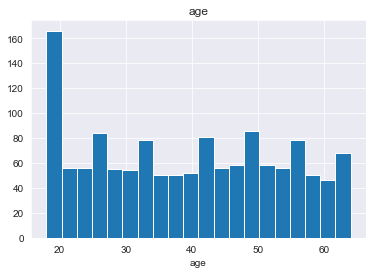

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
5%         21.256000
10%        22.990000
20%        25.326000
30%        27.360000
40%        28.797000
50%        30.400000
60%        32.032000
70%        33.660000
80%        35.860000
90%        38.619500
95%        41.106000
99%        46.407900
max        53.130000
Name: bmi, dtype: float64



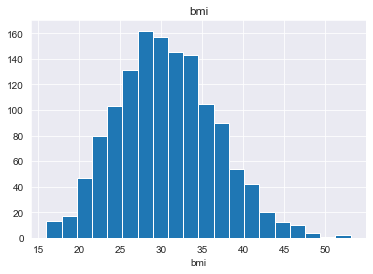

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
5%        1757.753400
10%       2346.533615
20%       3991.575720
30%       5484.846770
40%       7369.052730
50%       9382.033000
60%      11399.857160
70%      13767.875345
80%      20260.626406
90%      34831.719700
95%      41181.827787
99%      48537.480726
max      63770.428010
Name: charges, dtype: float64



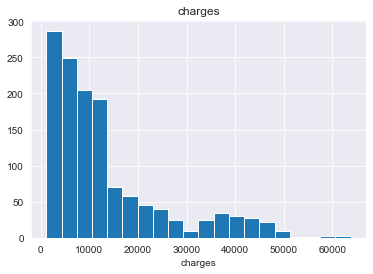

In [15]:
# numerik degiskenleri analiz edelim

for col in num_col:
    num_summary(df, col, True)

        sex      Ratio
male    676  50.523169
female  662  49.476831
##########################################


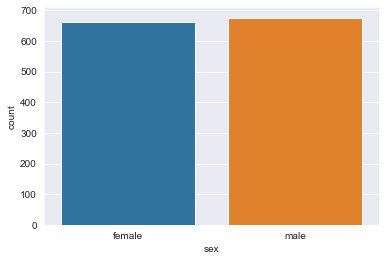

     smoker      Ratio
no     1064  79.521674
yes     274  20.478326
##########################################


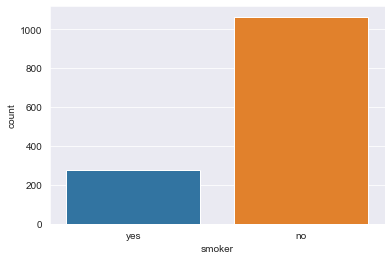

           region      Ratio
southeast     364  27.204783
southwest     325  24.289985
northwest     325  24.289985
northeast     324  24.215247
##########################################


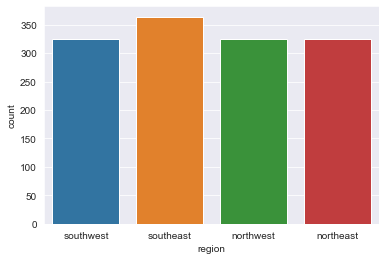

   children      Ratio
0       574  42.899851
1       324  24.215247
2       240  17.937220
3       157  11.733931
4        25   1.868460
5        18   1.345291
##########################################


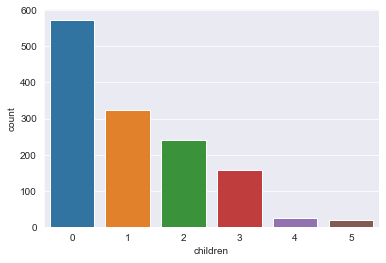

In [16]:
# kategorik degiskenleri analiz edelim

for col in cat_col:
    cat_summary(df, col, True)

In [17]:
# charges ile kategorik degiskenleri analiz edelim

for col in cat_col:
    target_summary_with_cat(df, 'charges', col)

         TARGET_MEAN
sex                 
female  12569.578844
male    13956.751178


         TARGET_MEAN
smoker              
no       8434.268298
yes     32050.231832


            TARGET_MEAN
region                 
northeast  13406.384516
northwest  12417.575374
southeast  14735.411438
southwest  12346.937377


           TARGET_MEAN
children              
0         12365.975602
1         12731.171832
2         15073.563734
3         15355.318367
4         13850.656311
5          8786.035247




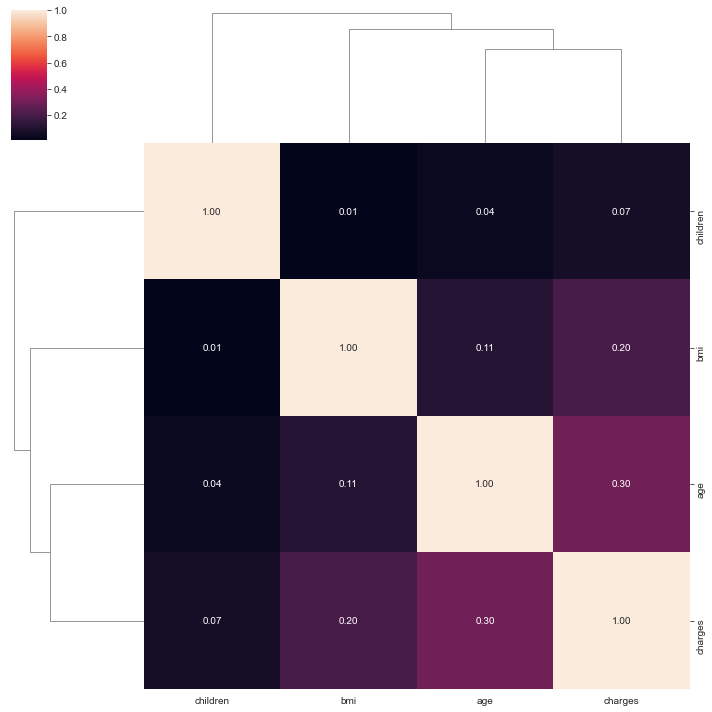

['age', 'bmi', 'children', 'charges']

In [18]:
# kolerasyon analizi

target_correlation_matrix(dataframe=df, corr_th=0.01, target='charges')

In [19]:
################## Data Pre Proc ##############

# outlier kontrol

for col in num_col:
    print(col, check_outlier(df, col, 0.01, 0.99))
# outlier gorunmuyor

age False
bmi False
charges False


In [20]:
# ENCODING

dff = df.copy()
dff.shape  # (1338,7)

(1338, 7)

In [21]:
cat_col, num_col, cat_but_car = grab_col_names(dff)


Observations: 1338
Variables: 7
cat_cols: 4
num_cols: 3
cat_but_car: 0
num_but_cat: 1


In [22]:
dff = one_hot_encoder(dataframe=dff, categorical_cols=cat_col, drop_first=True)
dff.head()

,age,bmi,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,children_1,children_2,children_3,children_4,children_5
0,19,27.900,16884.92400,0,1,0,0,1,0,0,0,0,0
1,18,33.770,1725.55230,1,0,0,1,0,1,0,0,0,0
2,28,33.000,4449.46200,1,0,0,1,0,0,0,1,0,0
3,33,22.705,21984.47061,1,0,1,0,0,0,0,0,0,0
4,32,28.880,3866.85520,1,0,1,0,0,0,0,0,0,0


In [23]:
cat_col, num_col, cat_but_car=grab_col_names(dff)

Observations: 1338
Variables: 13
cat_cols: 10
num_cols: 3
cat_but_car: 0
num_but_cat: 10


In [24]:
dff.shape  # (1338,13)

(1338, 13)

In [25]:
##################### RobustScaler####################

scaler = RobustScaler()

dff[num_col] = scaler.fit_transform(dff[num_col])
dff[num_col].head()

,age,bmi,charges
0,-0.833333,-0.297708,0.630515
1,-0.875000,0.401310,-0.643422
2,-0.458333,0.309616,-0.414515
3,-0.250000,-0.916344,1.059062
4,-0.291667,-0.181006,-0.463475


In [26]:
#HOLD-OUT
X = dff.drop('charges', axis=1)
y = dff['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    train_size=0.8,
                                                    random_state=42)

In [27]:
#################### ALL MODELS #####################

allmodel = all_models(X, y, test_size=0.2,
                      random_state=42,
                      classification=False)

C:\ProgramData\Anaconda3\envs\batuhan\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


          name  RMSE_TRAIN  RMSE_TEST  R2_TRAIN   R2_TEST
8          GBM    0.326849   0.366652  0.895192  0.877384
11    CatBoost    0.229187   0.379183  0.948468  0.868860
10    LightGBM    0.245958   0.383145  0.940650  0.866105
6           RF    0.159045   0.385091  0.975184  0.864741
7          SVR    0.380032   0.401181  0.858310  0.853202
9      XGBoost    0.082171   0.409430  0.993376  0.847103
0           LR    0.511608   0.488253  0.743213  0.782566
1        Ridge    0.511634   0.488530  0.743186  0.782319
5         CART    0.041531   0.546665  0.998308  0.727428
4          KNN    0.431092   0.568865  0.817678  0.704841
2        Lasso    1.009603   1.047563  0.000000 -0.000919
3   ElasticNet    1.009603   1.047563  0.000000 -0.000919


In [28]:
################## GradientBoostingRegressor GBM  ##################

gbm_model = GradientBoostingRegressor(random_state=17).fit(X_train, y_train)

gbm_test_y_pred = gbm_model.predict(X_test)
gbm_train_y_pred = gbm_model.predict(X_train)

In [29]:
# RMSE Train 0.3268491320398345
np.sqrt(mean_squared_error(y_train, gbm_train_y_pred))

0.3268491320398345

In [30]:
# RMSE Test 0.3664080358335804
np.sqrt(mean_squared_error(y_test, gbm_test_y_pred))

0.3664080358335804

In [31]:
cv_results = cross_validate(gbm_model, X, y, cv=10, scoring=['r2',
                                                             'neg_root_mean_squared_error'])

In [32]:
# 10-katli CV RMSE 0.3807177175226665
np.abs(cv_results['test_neg_root_mean_squared_error'].mean())

0.3807177175226665

In [33]:
# 10-katli R2 0.8550530183811695
cv_results['test_r2'].mean()

0.8550530183811695

In [34]:
r2_score(y_test, gbm_test_y_pred)

0.8775472629911887

In [35]:
#HiperParametre opti.
gbm_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [36]:
gbm_params= {'learning_rate' : [0.1,0.01,0.001,0.02,0.02],
            'max_depth' : np.random.randint(5,50,10),
            'max_features' : [7,9,11,13,'auto','sqrt',None],
            'n_estimators' : [int(x) for x in np.linspace(start=200,stop=1500,num=10)],
            'min_samples_split': np.random.randint(2, 50, 20)}

In [37]:
rf_random = RandomizedSearchCV(estimator=gbm_model,
                               param_distributions=gbm_params,
                               n_iter=100,  # denenecek parametre sayısı
                               cv=5,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1).fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [38]:
rf_random.best_params_

{'n_estimators': 344,
 'min_samples_split': 48,
 'max_features': 9,
 'max_depth': 25,
 'learning_rate': 0.01}

In [39]:
# RandomizedSearchCV den gelen best parametreler ile yeni model kuralim
gbm_random_model = gbm_model.set_params(**rf_random.best_params_,random_state=42)
gbm_random_model.fit(X_train,y_train)

gbm_random_test_y_pred = gbm_random_model.predict(X_test)
gbm_random_train_y_pred = gbm_random_model.predict(X_train)

In [40]:
# Random Model RMSE Train 0.2903421404414405
np.sqrt(mean_squared_error(y_train, gbm_random_train_y_pred))

0.24645473368468984

In [41]:
# Random Model RMSE Test 0.36371427619583596
np.sqrt(mean_squared_error(y_test, gbm_random_test_y_pred))

0.38181269062498335

In [42]:
# Train R2 0.9172973899560669
r2_score(y_train, gbm_random_train_y_pred)

0.9404099985893851

In [43]:
# Test R2 0.8793411413015468
r2_score(y_test, gbm_random_test_y_pred)

0.8670344189399704

In [44]:
# 10-katli model dogrulama
cv_results = cross_validate(gbm_random_model, X, y, cv=10, scoring=['r2',
                                                             'neg_root_mean_squared_error'])

In [45]:
# 10-katli CV RMSE 0.3885297111980683
np.abs(cv_results['test_neg_root_mean_squared_error'].mean())

0.402429423144621

In [46]:
# 10-katli R2 0.8496355398360815
cv_results['test_r2'].mean()

0.8389697884169977

ILK GBM MODELI SADECE RANDOMIZEDSEARCHCV OPTIMIZASYONUNDAN SONRAKI METRIKLERI
* RMSE Train 0.2903421404414405
* RMSE Test 0.36371427619583596
* 10-katli CV RMSE 0.3885297111980683
* Test R2 0.8793411413015468
* Train R2 0.9172973899560669
* 10-katli R2 0.8496355398360815



In [47]:
rf_random.best_params_

{'n_estimators': 344,
 'min_samples_split': 48,
 'max_features': 9,
 'max_depth': 25,
 'learning_rate': 0.01}

In [48]:
grid_params = {'n_estimators': [100,200,344,400],
 'min_samples_split': [2,40,45,50],
 'max_features': [8,9,10,12,13,'sqrt'],
 'max_depth': [3,6,34,40],
 'learning_rate': [0.001,0.01,0.02,0.1]}

In [49]:
grid_best_params = GridSearchCV(gbm_model,
                               grid_params,
                               cv=5,
                               verbose=True,
                               n_jobs=-1).fit(X,y)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


In [50]:
grid_best_params.best_params_

{'learning_rate': 0.02,
 'max_depth': 3,
 'max_features': 10,
 'min_samples_split': 50,
 'n_estimators': 344}

In [51]:
gbm_final = gbm_model.set_params(**grid_best_params.best_params_,
                                      random_state=42).fit(X_train,y_train)

gbm_final_y_train_pred = gbm_final.predict(X_train)
gbm_final_y_test_pred = gbm_final.predict(X_test)

In [52]:
# Final Model RMSE Train 0.3447844712238112
np.sqrt(mean_squared_error(y_train, gbm_final_y_train_pred))

0.3447844712238112

In [53]:
# Final Model RMSE Test 0.3670736477378173
np.sqrt(mean_squared_error(y_test, gbm_final_y_test_pred))

0.3670736477378173

In [54]:
# Train R2 0.8833742466231238
r2_score(y_train, gbm_final_y_train_pred)

0.8833742466231238

In [55]:
#Test R2 0.8771019669123271
r2_score(y_test, gbm_final_y_test_pred)

0.8771019669123271

In [56]:
cv_results = cross_validate(gbm_final, X, y, cv=10, scoring=['r2',
                                                             'neg_root_mean_squared_error'])

In [57]:
# 10-katli R2 0.8585921530169509
cv_results['test_r2'].mean()

0.8585921530169509

In [58]:
# 10-katli CV RMSE 0.37600348030814185
np.abs(cv_results['test_neg_root_mean_squared_error'].mean())

0.37600348030814185

GBM final : 
* RMSE Train 0.3447844712238112
* RMSE Test 0.3670736477378173
* 10-katli CV RMSE 0.37600348030814185
* Train R2 0.8833742466231238
* Test R2 0.8771019669123271
* 10-katli R2 0.8585921530169509

# Feature Extract

In [59]:
dff2 = df.copy()

check_df(dff2)

##################### Shape #####################
(1338, 7)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
##################### Head #####################
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
##################### Tail #####################
      age     sex    bmi  children smoker     region     charges
1333   50    male  30.97         3     no  northwest  10600.5483
1334   18  female  31.92         0     no  northeast   2205.9808
1335   18  female  36.85         0     no  southeast   1629

In [60]:
# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması
dff2.loc[(dff2["age"] < 21), "new_age_cat"] = "genc"
dff2.loc[(dff2["age"] >= 21) & (dff2["age"] < 50), "new_age_cat"] = "yetiskin"
dff2.loc[(dff2["age"] >= 50), "new_age_cat"] = "yasli"

In [61]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez
dff2['new_bmi'] = pd.cut(x=dff2['bmi'], bins=[0, 18.5, 24.9, 29.9, 100],
                         labels=['zayif', 'normal', 'kilolu', 'obez'])

In [62]:
# Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma

dff2.loc[(dff2['bmi'] < 18.5) & (dff2['age'] < 21), 'new_age_bmi_nom'] = 'zayif_genc'

dff2.loc[(dff2['bmi'] < 18.5) & ((dff2['age'] >= 21) & (dff2['age'] < 50)), 'new_age_bmi_nom'] = 'zayif_yetiskin'

dff2.loc[(dff2['bmi'] < 18.5) & (dff2['age'] >= 50), 'new_age_bmi_nom'] = 'zayif_yasli'

dff2.loc[((dff2['bmi'] >= 18.5) & (dff2['bmi'] < 25)) & (dff2['age'] < 21), 'new_age_bmi_nom'] = 'normal_genc'

dff2.loc[((dff2['bmi'] >= 18.5) & (dff2['bmi'] < 25)) & (
        (dff2['age'] >= 21) & (dff2['age'] < 50)), 'new_age_bmi_nom'] = 'normal_yetiskin'

dff2.loc[((dff2['bmi'] >= 18.5) & (dff2['bmi'] < 25)) & (dff2['age'] >= 50), 'new_age_bmi_nom'] = 'normal_yasli'

dff2.loc[((dff2['bmi'] >= 25) & (dff2['bmi'] < 30)) & (dff2['age'] < 21), 'new_age_bmi_nom'] = 'kilolu_genc'

dff2.loc[((dff2['bmi'] >= 25) & (dff2['bmi'] < 30)) & (
        (dff2['age'] >= 21) & (dff2['age'] < 50)), 'new_age_bmi_nom'] = 'kilolu_yetiskin'

dff2.loc[((dff2['bmi'] >= 25) & (dff2['bmi'] < 30)) & (dff2["age"] >= 50), 'new_age_bmi_nom'] = 'kilolu_yasli'

dff2.loc[(dff2['bmi'] > 29.9) & (dff2['age'] < 21), 'new_age_bmi_nom'] = 'obez_genc'

dff2.loc[(dff2['bmi'] > 29.9) & ((dff2['age'] >= 21) & (dff2['age'] < 50)), 'new_age_bmi_nom'] = 'obez_yetiskin'

dff2.loc[(dff2['bmi'] > 29.9) & (dff2['age'] >= 50), 'new_age_bmi_nom'] = 'obez_yasli'


In [63]:
# genc-yetiskin-yasli(new_age_cat) ile sigara(smoker) bir arada dusunelim

dff2.loc[(dff2['new_age_cat'] == 'genc') & (dff2['smoker'] == 'yes'), 'new_age_smoker'] = 'genc_smoker'
dff2.loc[(dff2['new_age_cat'] == 'genc') & (dff2['smoker'] == 'no'), 'new_age_smoker'] = 'genc_not_smoker'

dff2.loc[(dff2['new_age_cat'] == 'yetiskin') & (dff2['smoker'] == 'yes'), 'new_age_smoker'] = 'yetiskin_smoker'
dff2.loc[(dff2['new_age_cat'] == 'yetiskin') & (dff2['smoker'] == 'no'), 'new_age_smoker'] = 'yetiskin_not_smoker'

dff2.loc[(dff2['new_age_cat'] == 'yasli') & (dff2['smoker'] == 'yes'), 'new_age_smoker'] = 'yasli_smoker'
dff2.loc[(dff2['new_age_cat'] == 'yasli') & (dff2['smoker'] == 'no'), 'new_age_smoker'] = 'yasli_not_smoker'


In [64]:
# smoker ve obezleri(new_bmi) birlikte dusunelim

dff2['new_smoker_and_obez'] = dff2.apply(lambda x: 'yes' if (x['smoker'] == 'yes') & (x['new_bmi'] == 'obez') else 'no',
                                         axis=1)

In [65]:
# smoker ve yaslilari birlikte dusunelim

dff2['new_smoker_and_yasli'] = dff2.apply(
    lambda x: 'yes' if (x['smoker'] == 'yes') & (x['new_age_cat'] == 'yasli') else 'no', axis=1)

In [66]:
# age / children degiskeni

dff2['new_age/children'] = dff2['age'] / (dff2['children'] + 1)

In [67]:
check_df(dff2)

##################### Shape #####################
(1338, 14)
##################### Types #####################
age                        int64
sex                       object
bmi                      float64
children                   int64
smoker                    object
region                    object
charges                  float64
new_age_cat               object
new_bmi                 category
new_age_bmi_nom           object
new_age_smoker            object
new_smoker_and_obez       object
new_smoker_and_yasli      object
new_age/children         float64
dtype: object
##################### Head #####################
   age     sex     bmi  children smoker     region      charges new_age_cat  \
0   19  female  27.900         0    yes  southwest  16884.92400        genc   
1   18    male  33.770         1     no  southeast   1725.55230        genc   
2   28    male  33.000         3     no  southeast   4449.46200    yetiskin   
3   33    male  22.705         0     no  northwe

In [68]:
# kategorik ve numerik degiskenleri yakalayalim
cat_col, num_col, cat_but_car = grab_col_names(dff2)

Observations: 1338
Variables: 14
cat_cols: 10
num_cols: 4
cat_but_car: 0
num_but_cat: 2


In [69]:
# ENCODING

dff2 = one_hot_encoder(dff2, cat_col, True)
check_df(dff2)

##################### Shape #####################
(1338, 37)
##################### Types #####################
age                                     int64
bmi                                   float64
charges                               float64
new_age/children                      float64
sex_male                                uint8
smoker_yes                              uint8
region_northwest                        uint8
region_southeast                        uint8
region_southwest                        uint8
new_age_cat_yasli                       uint8
new_age_cat_yetiskin                    uint8
new_age_bmi_nom_kilolu_yasli            uint8
new_age_bmi_nom_kilolu_yetiskin         uint8
new_age_bmi_nom_normal_genc             uint8
new_age_bmi_nom_normal_yasli            uint8
new_age_bmi_nom_normal_yetiskin         uint8
new_age_bmi_nom_obez_genc               uint8
new_age_bmi_nom_obez_yasli              uint8
new_age_bmi_nom_obez_yetiskin           uint8
new_age_bmi_nom

In [70]:
cat_col, num_col, cat_but_car = grab_col_names(dff2)

Observations: 1338
Variables: 37
cat_cols: 33
num_cols: 4
cat_but_car: 0
num_but_cat: 33


In [71]:
# Scale

scaler = RobustScaler()
dff2[num_col] = scaler.fit_transform(dff2[num_col])
check_df(dff2)

##################### Shape #####################
(1338, 37)
##################### Types #####################
age                                   float64
bmi                                   float64
charges                               float64
new_age/children                      float64
sex_male                                uint8
smoker_yes                              uint8
region_northwest                        uint8
region_southeast                        uint8
region_southwest                        uint8
new_age_cat_yasli                       uint8
new_age_cat_yetiskin                    uint8
new_age_bmi_nom_kilolu_yasli            uint8
new_age_bmi_nom_kilolu_yetiskin         uint8
new_age_bmi_nom_normal_genc             uint8
new_age_bmi_nom_normal_yasli            uint8
new_age_bmi_nom_normal_yetiskin         uint8
new_age_bmi_nom_obez_genc               uint8
new_age_bmi_nom_obez_yasli              uint8
new_age_bmi_nom_obez_yetiskin           uint8
new_age_bmi_nom

In [72]:
cat_col, num_col, cat_but_car = grab_col_names(dff2)

Observations: 1338
Variables: 37
cat_cols: 33
num_cols: 4
cat_but_car: 0
num_but_cat: 33


In [73]:
# Outlier kontrol

for col in num_col:
    print(col,check_outlier(dff2,col,q1=0.05,q3=0.95))

age False
bmi False
charges False
new_age/children False


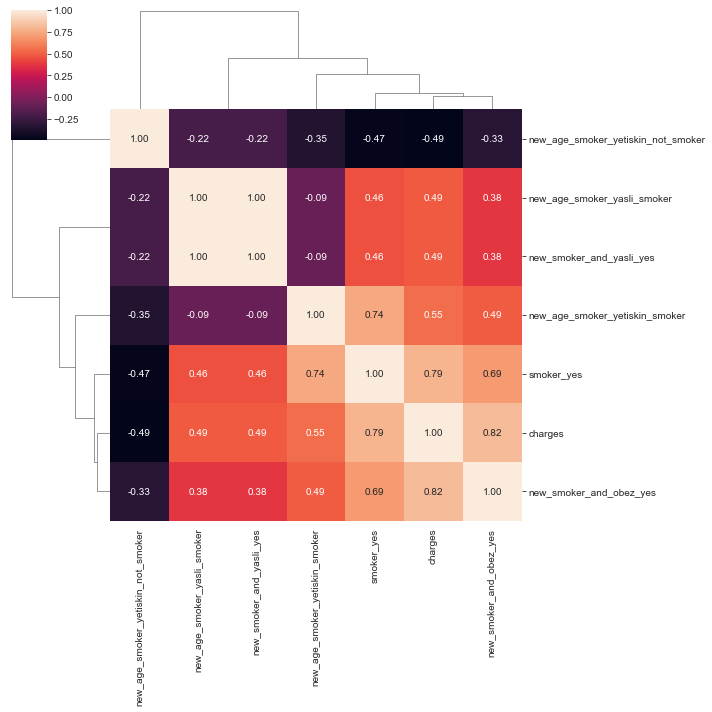

['charges',
 'smoker_yes',
 'new_age_smoker_yasli_smoker',
 'new_age_smoker_yetiskin_not_smoker',
 'new_age_smoker_yetiskin_smoker',
 'new_smoker_and_obez_yes',
 'new_smoker_and_yasli_yes']

In [74]:
# Korelasyon Analizi
target_correlation_matrix(dff2, 0.3, 'charges')

# ALL MODELS

In [75]:
# Korelasyona bagli eleme olmadan tum degiskenler modele dahil

X = dff2.drop('charges', axis=1)
y = dff2['charges']

allmodel = all_models(X, y, test_size=0.2,random_state=42,classification=False)

C:\ProgramData\Anaconda3\envs\batuhan\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


          name  RMSE_TRAIN  RMSE_TEST  R2_TRAIN   R2_TEST
8          GBM    0.314725   0.361891  0.902824  0.880548
1        Ridge    0.377112   0.367910  0.860479  0.876541
11    CatBoost    0.216325   0.368813  0.954089  0.875934
7          SVR    0.363138   0.374528  0.870627  0.872060
6           RF    0.162190   0.376458  0.974193  0.870738
10    LightGBM    0.236465   0.384536  0.945143  0.865131
0           LR    0.375406   0.391822  0.861738  0.859972
9      XGBoost    0.072017   0.417554  0.994912  0.840976
4          KNN    0.343425   0.418147  0.884292  0.840524
5         CART    0.041531   0.522290  0.998308  0.751194
2        Lasso    1.009603   1.047563  0.000000 -0.000919
3   ElasticNet    1.009603   1.047563  0.000000 -0.000919


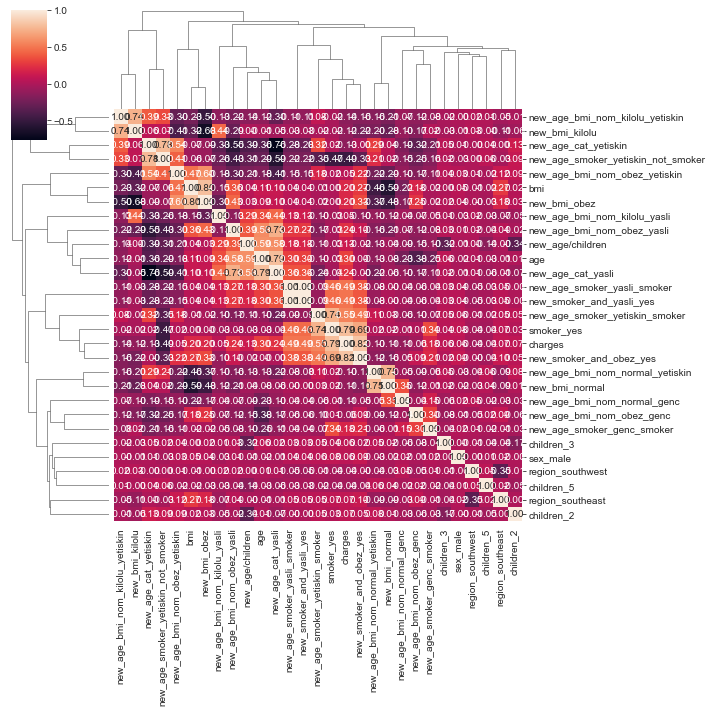

In [76]:
# Kucuk bir Korelasyon elemesi
cor_list = target_correlation_matrix(dataframe=dff2, 
                                     corr_th=0.04105, # esik degeri dusurduk
                                     target='charges')

In [77]:
X = dff2[cor_list].drop('charges', axis=1)
y = dff2['charges']

allmodel = all_models(X, y, 
                      test_size=0.2,
                      random_state=42,
                      classification=False)

C:\ProgramData\Anaconda3\envs\batuhan\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


          name  RMSE_TRAIN  RMSE_TEST  R2_TRAIN   R2_TEST
8          GBM    0.317581   0.357897  0.901052  0.883170
1        Ridge    0.379204   0.369166  0.858927  0.875697
11    CatBoost    0.228688   0.373695  0.948692  0.872628
6           RF    0.161130   0.376674  0.974529  0.870590
7          SVR    0.365645   0.377936  0.868835  0.869721
0           LR    0.378500   0.378468  0.859450  0.869354
10    LightGBM    0.238220   0.383221  0.944325  0.866052
4          KNN    0.346126   0.404381  0.882465  0.850851
9      XGBoost    0.080949   0.419288  0.993571  0.839652
5         CART    0.041531   0.510626  0.998308  0.762183
2        Lasso    1.009603   1.047563  0.000000 -0.000919
3   ElasticNet    1.009603   1.047563  0.000000 -0.000919


<b> GBM MODEL KURULARAK HIPERPARAMETRE OPTIMIZASYONLARI ILE DEVAM EDILMELI